In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Import libraries**

In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy
from sklearn.preprocessing import StandardScaler
from scipy import sparse
import matplotlib.pyplot as plt
import gensim
from gensim.models import KeyedVectors
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from seaborn import scatterplot as scatter
from gensim.models.doc2vec import Doc2Vec
from numpy import linalg as LA
from sklearn.metrics import silhouette_score,calinski_harabasz_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Load Processed data**

Loading the preprocessed doc2vec data 

In [0]:
input_file="./drive/My Drive/CS235Project/Doc2Vec/PV_DM_prcsd.doc2vec"
model = Doc2Vec.load(input_file)
doc_tags = list(model.docvecs.doctags.keys())
X = model[doc_tags]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# **Dimensionality Reduction using TSNE**

Here, we are using TSNE to transform the data into a lower dimension vector

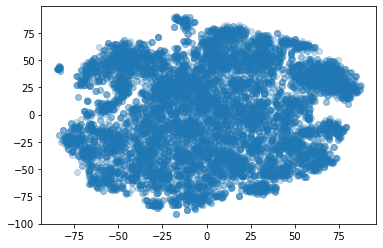

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=20,learning_rate=1000)
X_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
plt.scatter(df_tsne['Dim1'], df_tsne['Dim2'], alpha=0.25)
plt.show()

# **Fuzzy Cmeans Implementation**

Implementation of Fuzzy C-means with Z-normalization and Eucidean Distance

In [0]:
import numpy as np
import math

class fuzzy_cmeans(object):
    __author__="Madhurima Chakraborty"
    __email__="mchak009@ucr.edu"
    def __init__(self, no_of_clusters, iterations=100):
        """Default constructor to initialize the class object.

           Args:
                iterations: The maximum number of iterations allowed
                no_of_clusters: The number of clusters to be formed
        """
        self.iterations = iterations
        self.no_of_clusters = no_of_clusters
        self.centroids = None
        self.clusters = None
        self.membership = None
  
    def minkowski_distance(self, p=2):
        """Finds the Minkowski distance (also called p-norm)

            Args:
                data: The normalized dataset

            Returns:
                distances: The distances beteen the data points and the centroids
        """
        distances = []
        for i in range(self.centroids.shape[0]):
            diff = np.absolute(self.data - self.centroids[i])
            #calculating Chebychev Distance
            dist = [LA.norm(d, p) for d in diff]
            distances.append(dist)

        distances= np.array(distances)

        return distances
        
    def get_labels(self):
        """Get the cluster label for the data based on the fuzzy membership
            Args:
                None
            Returns:
                labels: The labels of the clusters formed
        """
        labels = list()
        for member in np.transpose(self.membership):
            labels.append(np.argmax(member))

        return labels

    def z_normalization(self):
        """z-score normalization for transforming the data

            Args:
                None

            Returns:
                None
        """
        
        dims = self.data.shape[1]
        if dims != 0:
            std = np.std(self.data, axis=1)
            mean = np.mean(self.data, axis=1)
            for d in range(dims):
                self.data[:, d] = (self.data[:, d] - mean[d])/std[d]
        else:
            print("No data found")

    def membership_calculation(self, distances):
        """Computes the probabilistic (fuzzy) membership of the data points w.r.t. the clusters

            Args:
                distances: The distances of between the data points and the centroids

            Returns:
                members: The membership probabilities of belonging to different clusters
        """
        members= list()

        epsilon = 1e-8
        for i in range(self.centroids.shape[0]):
            # holds the membership probability for the i-th member
            member_i = list()    
            for d in np.transpose(distances):
                # smoothing to prevent division by zero
                member_i.append(np.power(d[i] + epsilon, -2) / np.sum(np.power(d + epsilon, -2)))   

            members.append(member_i)

        members = np.array(members)

        return members
    
    def centroid_calculation(self):
        """Compute the centroid based on the membership of the data points

            Args:
                None

            Returns:
                centroids: The centroid coordinates
        """
        centroids = []
        for i in range(self.no_of_clusters):
            # holds the centroid information for the i-th member    
            centroid_i = [] 
            for x in np.transpose(self.data):
                centroid_i.append(np.dot(np.power(self.membership[i], 2), x) / np.sum(np.power(self.membership[i], 2)))

            centroids.append(centroid_i)

        centroids = np.array(centroids)
        return centroids

    def dispersion(self):
      """Calculate the sum of errors

            Args:
                None

            Returns:
                disp: The sum of errors(dispersion) of clustering configuration
      """
      n_samples = self.data.shape[0]
      n_clusters = self.centroids.shape[0]
      n_features = self.data.shape[1]
      disp = 0.0
      labels = self.get_labels()
      
      for i in range(n_samples):
        j = labels[i]
        diff = np.absolute(self.data[i, :] - self.centroids[j])
        sq_dist = LA.norm(diff, 2)
        disp += sq_dist * 1

      disp /= n_samples
      return disp

    def clustering(self, X):
        """Performs fuzzy c-means clustering with respect to the data

            Args:
                X: The original dataset

            Returns:
                centroids: The final centroid coordinates after clustering 
        """
        self.data = copy.deepcopy(X)
        self.z_normalization()
        index = np.random.choice(self.data.shape[0],
                                 self.no_of_clusters,
                                 replace=False)
        self.centroids = self.data[index]
        distances = self.minkowski_distance()

        self.membership = self.membership_calculation(distances)
        self.clusters = self.get_labels()

        for iteration in range(self.iterations):

            self.centroids = self.centroid_calculation()
            distances = self.minkowski_distance()

            self.membership = self.membership_calculation(distances)
            self.clusters = self.get_labels()
                
        return self.centroids

# **Optimal Cluster Number Determination using Elbow Plot**

Here, we have used the dispersion of each clustering configuration to identify the optimal number of clusters

100%|██████████| 8/8 [12:40<00:00, 95.11s/it] 


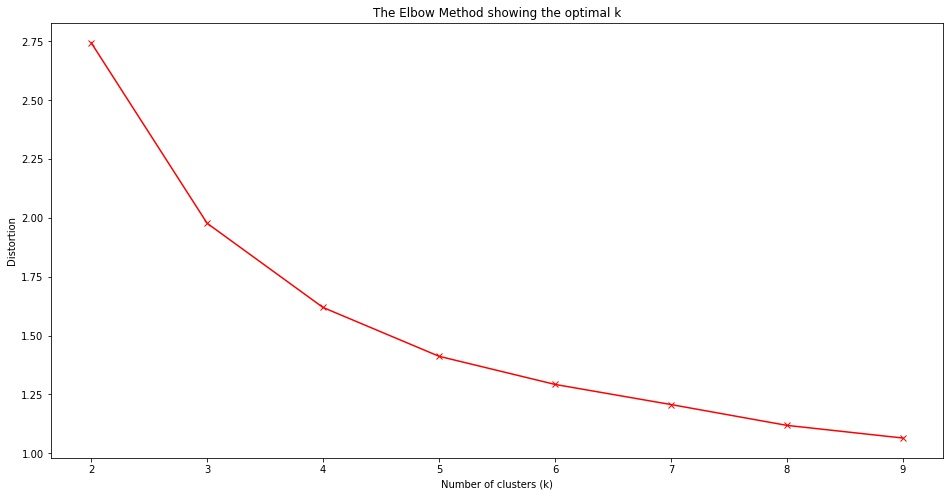

In [0]:
num_cluster = 10
distortions = []
for k in tqdm(range(2, num_cluster)):
    fcm_new = fuzzy_cmeans(no_of_clusters=k)
    fcm_new.clustering(X_tsne)
    distortions.append(fcm_new.dispersion())

K = range(2, num_cluster)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'rx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# **Fuzzy Cmeans Plotting**

Plotting the results for Fuzzy C-means

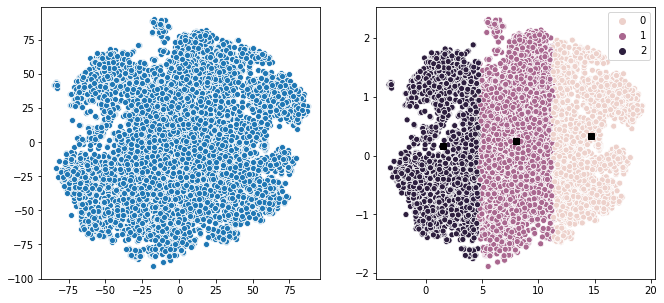

In [0]:
fcm_new = fuzzy_cmeans(iterations=300, no_of_clusters=3)
centroids = fcm_new.clustering(X_tsne)
labels = fcm_new.clusters
data = fcm_new.data
%matplotlib inline
f, axes = plt.subplots(1, 2, figsize=(11,5))
scatter(X_tsne[:,0], X_tsne[:,1], ax=axes[0])
scatter(data[:,0], data[:,1], ax=axes[1], hue=labels)
plt.plot(centroids[:,0], centroids[:,1], 's', color='black')
plt.show()

# **Compute Silhoutte and Calinski harabasz score as evaluation metrics**

To evaluate the performance of the Fuzzy C-means against other clustering techniques

In [0]:
silhouette_score(X_tsne, labels)

0.23193271

In [0]:
calinski_harabasz_score(X_tsne, labels)

3696.7254499111714

# **End**